In [30]:
import numpy as np
import pandas as pd
import emcee
import isochrones
from isochrones import SingleStarModel, get_ichrone
from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
from isochrones.priors import FlatPrior, DistancePrior, AgePrior, FehPrior, AVPrior, EEP_prior, GaussianPrior
import isochrones.priors as isopro
import astropy.units as u

from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
mpl.rcParams['axes.linewidth'] = 1.8
plt.rc('font', family='serif')
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm
import matplotlib as mpl

print("isochrones:", isochrones.__version__)
print("emcee:     ", emcee.__version__)


isochrones: 2.1
emcee:      3.1.6


## Initialize MIST model Tracks

In [31]:
track = MIST_EvolutionTrack()

In [32]:
mist = get_ichrone('mist', bands=["BP", "G", "RP", 
                            "W1", "W2", "J", "H", "K"])

# Data from Tzanida et al. 2025
obs = {'parallax': (0.1799, 0.2015), # from Gaia DR3 estimates
       "G": (18.7862, 0.0028), 
       "BP": (19.6814, 0.0584),
       "RP": (17.7094, 0.0194),
       "H": (15.4460, 0.0210),
       "J": (16.1860, 0.0850),
       "K": (15.4080, 0.2100)}

mod = SingleStarModel(mist, name='Gaia-GIC-1-v1', **obs)

In [33]:
mod.observed_quantities

['G_mag', 'BP_mag', 'RP_mag', 'H_mag', 'J_mag', 'K_mag', 'parallax']

## Initialize model priors

- [Fe/H] **uniform** priror $\mathcal{U}$(-1,0)
- distance **uniform** priror $\mathcal{U}$(3538,4688) based on [Bailer-Jones et al. 2021 ](https://ui.adsabs.harvard.edu/abs/2021AJ....161..147B/abstract)
- A $_{v}$  **uniform** priror $\mathcal{U}$(2. 4.5) based on the SFD dust extinction estimates at this line-of-sight [Schlegel et al. 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract)
- Age **uniform** prior $\mathcal{U}$(6.8, 8) which coresponds to (6.3, 100) Myr 


In [34]:
mod.set_prior(feh=FlatPrior((-1, 0)), 
              distance=FlatPrior((3538, 4688)), 
             AV=FlatPrior((2, 4.5)), age=FlatPrior((6.8, 8))
             )

In [35]:
# path where chains are saved
mod.mnest_basename

'./chains/Gaia-GIC-1-v1-mist-single-'

In [36]:
mod.fit(n_live_points=5_000)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 5000
 dimensionality =    5
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.999604
Replacements:                               5050
Total Samples:                              5052
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -179.185035 +/-  0.999901
Acceptance Rate:                        0.999412
Replacements:                               5100
Total Samples:                              5103
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):    -179.195079 +/-  0.999902
Acceptance Rate:                        0.999030
Replacements:                               5150


/opt/miniconda3/envs/astrobase2/lib/python3.9/site-packages/isochrones/starmodel.py:1645: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, names=self.param_names + ("lnprob",), delim_whitespace=True)


In [37]:
mod.samples.head()

eep       age       feh     distance        AV     lnprob
0  178.909053  6.879491 -0.272015  4340.618210  3.726994 -67.859712
1  183.408073  6.838507 -0.615416  4040.887478  4.172807 -65.266309
2  184.104971  6.936016 -0.083108  4503.937210  4.228042 -65.255260
3  182.466062  6.919732 -0.219695  4596.551986  3.794864 -64.956373
4  182.808417  6.839559 -0.459195  4598.227134  3.966769 -64.800661

In [38]:
mod.samples.describe()

eep           age           feh      distance            AV  \
count  21636.000000  21636.000000  21636.000000  21636.000000  21636.000000   
mean     182.582091      6.881295     -0.520466   3985.955691      3.934998   
std        3.236175      0.063081      0.218082    316.067243      0.171018   
min      171.989794      6.800027     -0.999653   3538.249050      3.405382   
25%      180.739493      6.831443     -0.682811   3715.734702      3.831510   
50%      182.377832      6.868890     -0.520796   3924.021686      3.942197   
75%      184.307148      6.916783     -0.366488   4222.239488      4.029653   
max      198.183017      7.141120     -0.000192   4687.972840      4.498987   

             lnprob  
count  21636.000000  
mean     -57.040562  
std        1.168464  
min      -67.859712  
25%      -57.539445  
50%      -56.749124  
75%      -56.217914  
max      -55.249212

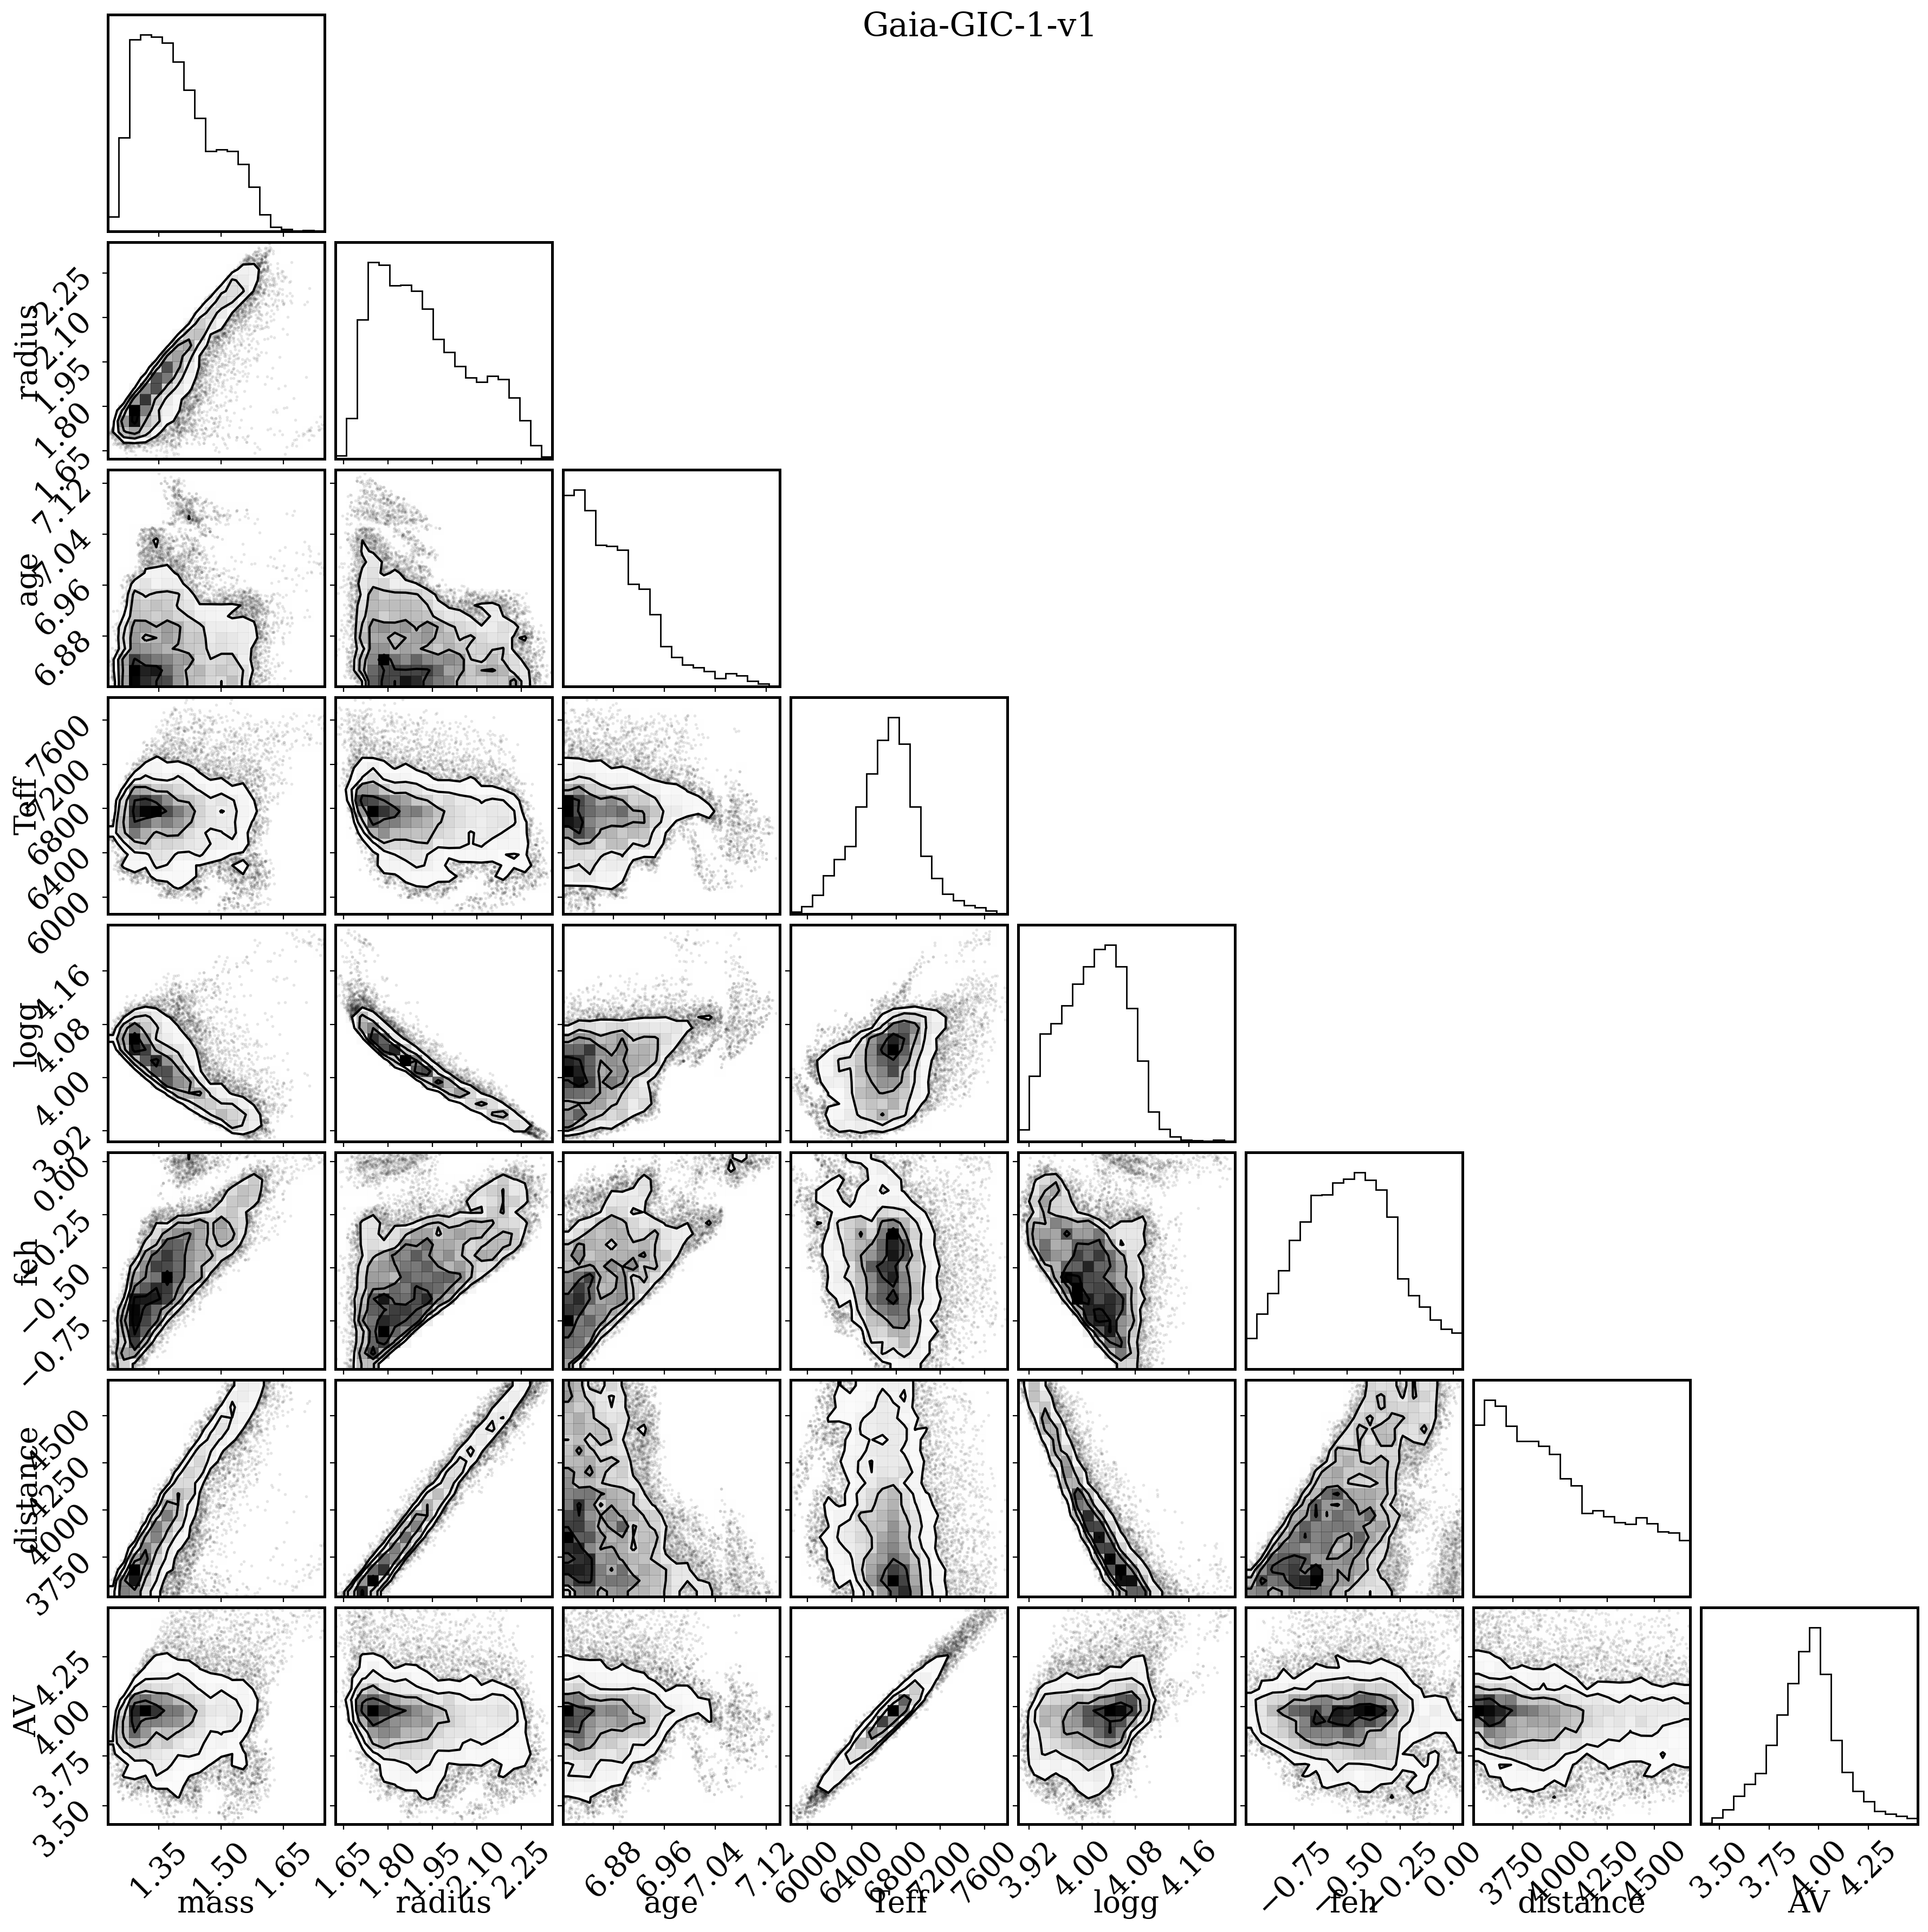

In [39]:
_ = mod.corner_physical()


/var/folders/xk/5g8l6b0d4r1dyg5f01jbjj800000gn/T/ipykernel_53821/4075463257.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


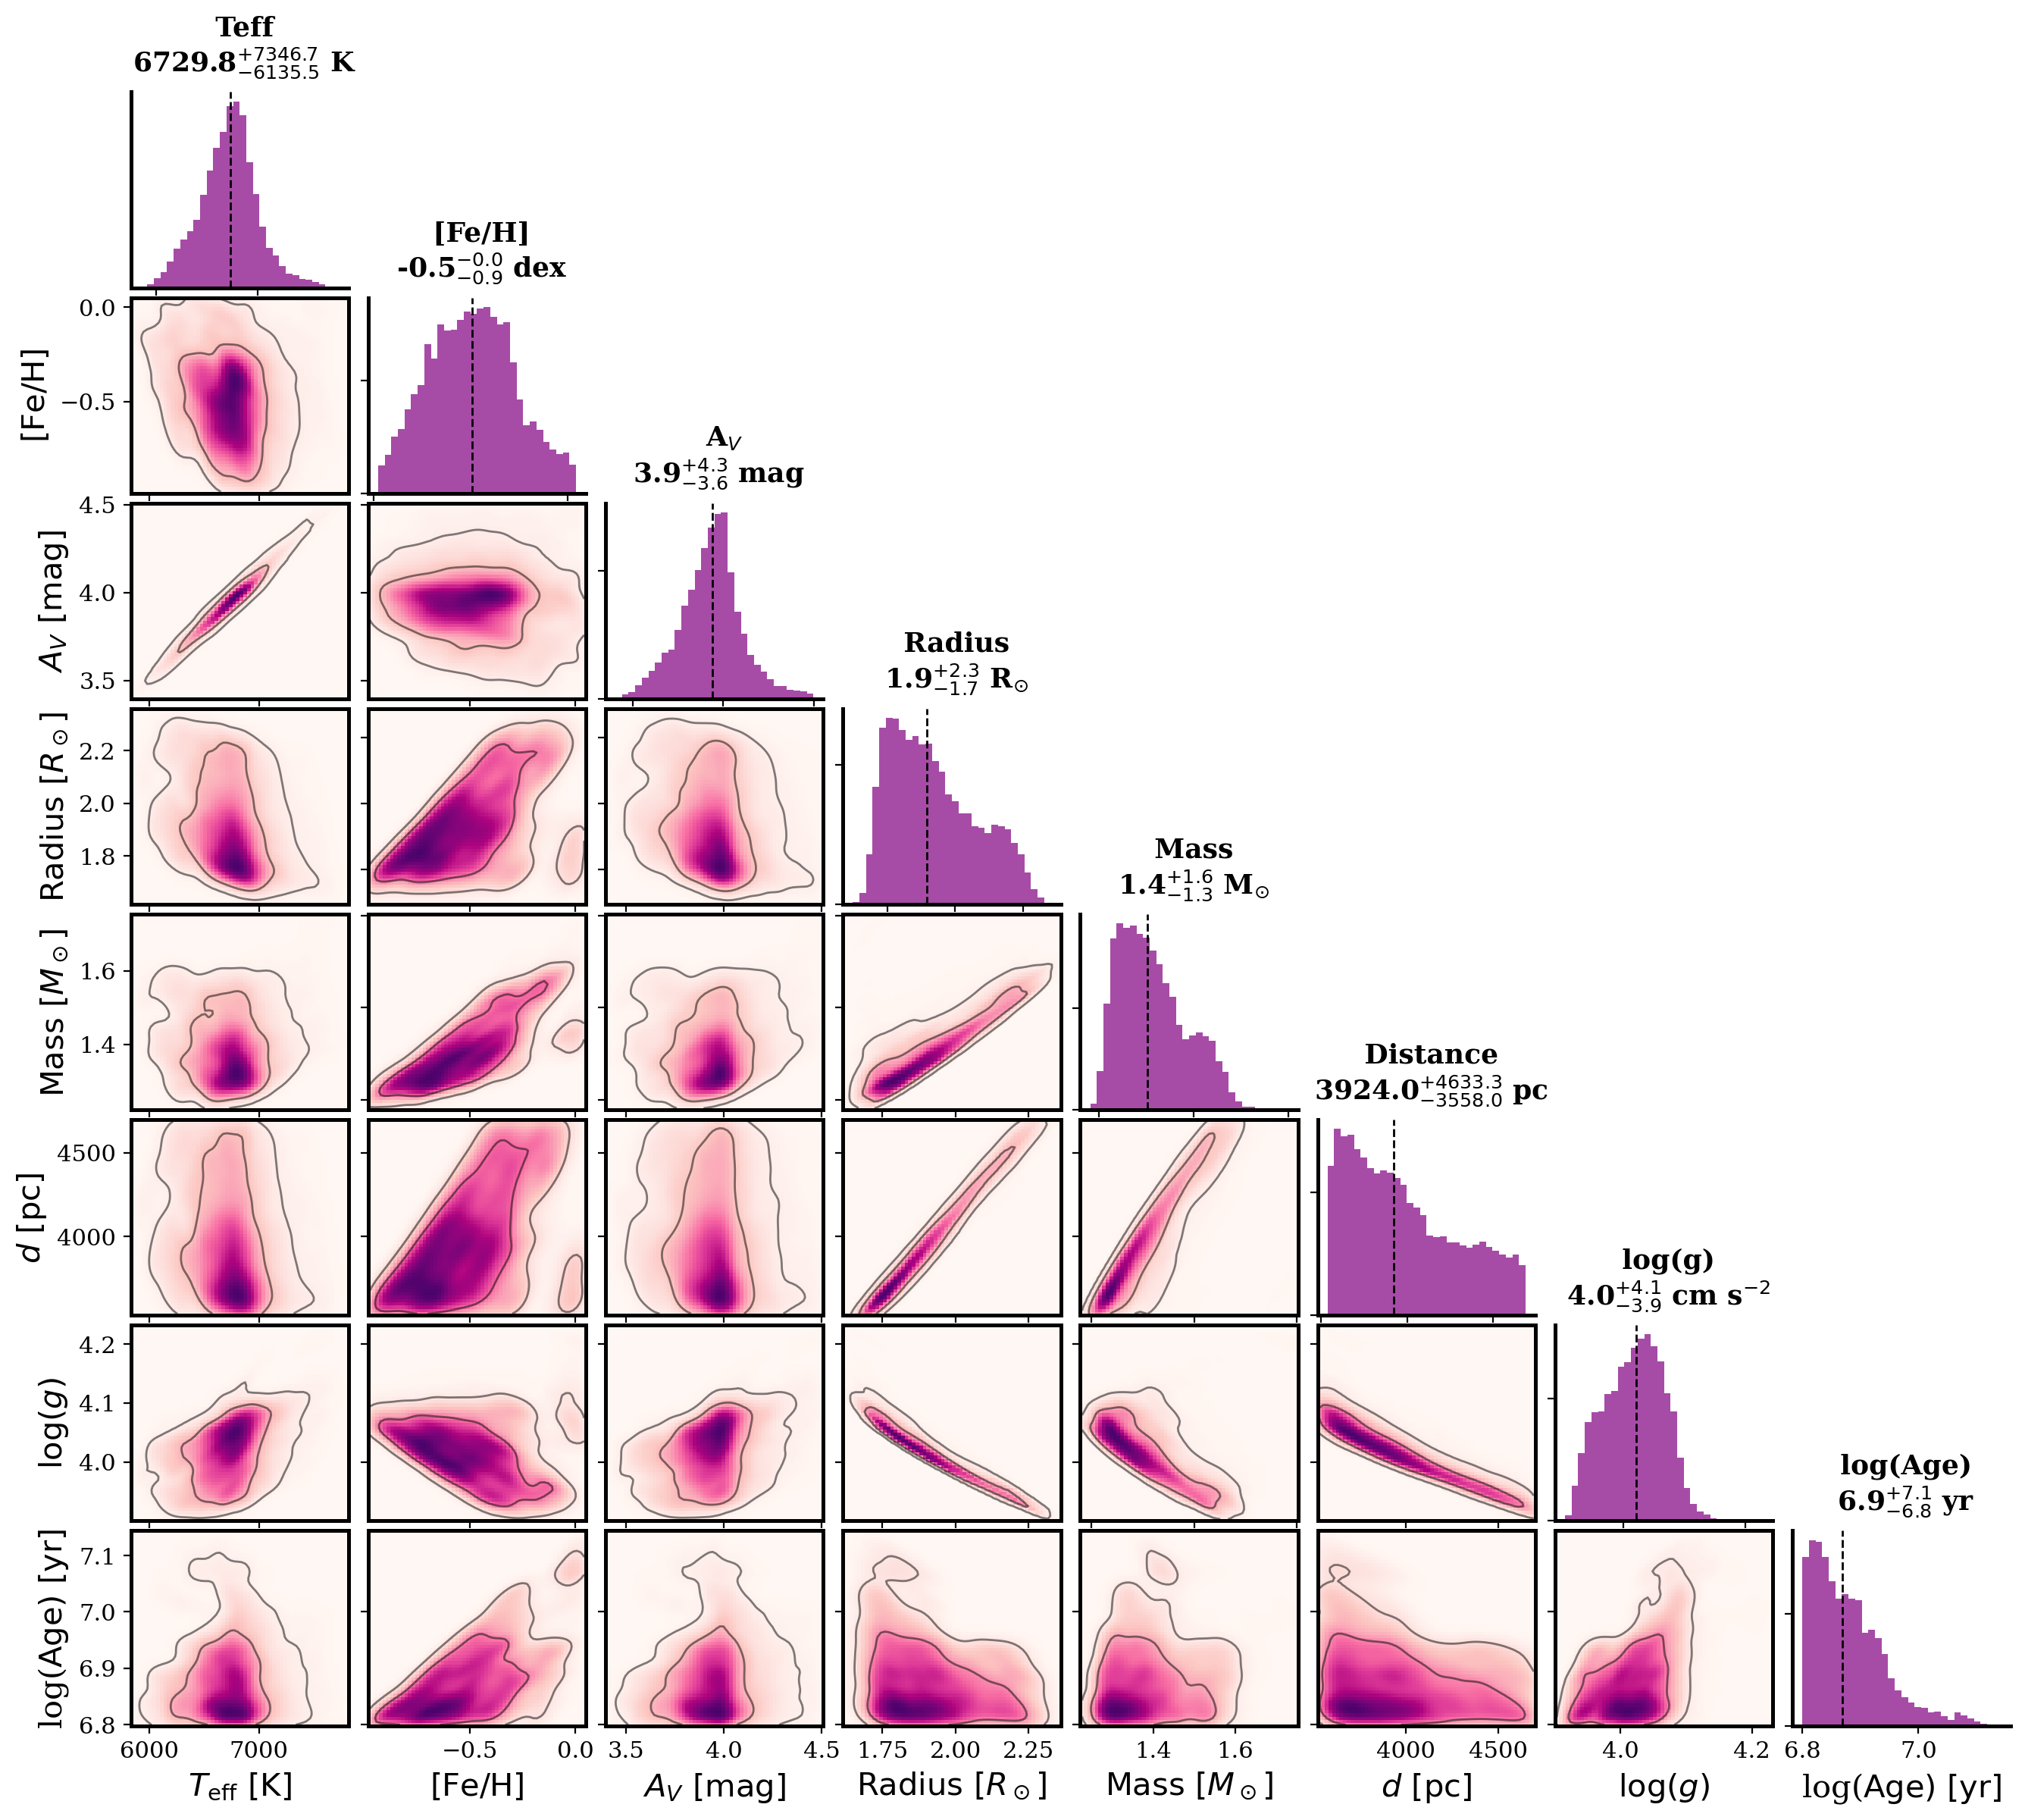

In [42]:
# columns to include in corner plot
cols_of_interest = ['Teff', "feh", "AV", "radius", "mass", "distance", "logg", "age"]
full_samp = mod.derived_samples[cols_of_interest].to_numpy() # select only relevant columns

ndim = full_samp.shape[1]

labels = [
    r"$T_{\mathrm{eff}}\ [\mathrm{K}]$",
    r"$\mathrm{[Fe/H]}$",
    r"$A_V\ [\mathrm{mag}]$",
    r"$\mathrm{Radius}\ [R_\odot]$",
    r"$\mathrm{Mass}\ [M_\odot]$",
    r"$d\ [\mathrm{pc}]$",
    r"$\log(g)$",
    r"log($\mathrm{Age})\ [\mathrm{yr}]$",
    ]

label_names = [
    "Teff", "[Fe/H]", "A$_V$", "Radius", "Mass", "Distance", "log(g)", "log(Age)"
    ]

units = [
    "K", "dex", "mag", "R$_{\odot}$", "M$_{\odot}$", "pc", "cm s$^{-2}$", "yr"
    ]


def plot_kde_smoothed(ax, x, y, gridsize=60, levels=(0.682, 0.954), cmap='RdPu'):
    """Plot 2D KDE smoothed density and contours on an Axes.
    
    Parameters
    ----------
    ax : matplotlib Axes
        The axes on which to plot.
    x : np.array
        x data points.
    y : np.array
        y data points.
    gridsize : int, optional
        Number of grid points along each axis, by default 60
    levels : tuple, optional
        Contour levels to plot, by default (0.682, 0.954)
    cmap : str, optional
        Colormap to use, by default 'RdPu'
    """

    values = np.vstack([x, y])
    kde = gaussian_kde(values) # gaussian kernel density estimate

    xi, yi = np.mgrid[x.min():x.max():gridsize*1j, y.min():y.max():gridsize*1j]
    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

    ax.pcolormesh(xi, yi, zi, shading='auto', cmap=cmap, alpha=0.99)

    z_sorted = np.sort(zi.ravel())
    z_cumsum = np.cumsum(z_sorted)
    z_cumsum /= z_cumsum[-1] # normalize to 1

    contour_levels = sorted([z_sorted[np.searchsorted(z_cumsum, 1 - lvl)] for lvl in levels])

    ax.contour(xi, yi, zi, levels=contour_levels, colors='black', linewidths=1, alpha=0.5)

w_dim, h_dim = 0.09, 0.05 # dimensions of sub-grid spacing
fig = plt.figure(figsize=(16,14))
gs = GridSpec(ndim, ndim, figure=fig, wspace=w_dim, hspace=h_dim)

for i in range(ndim):
    for j in range(ndim):
        ax=fig.add_subplot(gs[i, j])

        if i == j:
            data = full_samp[:, j]
            ax.hist(data, bins=30, color='purple', alpha=0.7, density=True)
            median = np.median(data)
            sigma = np.std(data)
            percentiles = np.percentile(data, [2.28, 50, 97.7]) # 2-sigma percentiles

            name = label_names[j]
            unit = units[j]

            if unit=='dex':
                label_text = f"  {name} \n {percentiles[1]:.1f}$^{{{percentiles[2]:.1f}}}_{{{percentiles[0]:.1f}}}$ {unit}"
            else:
                label_text = f"  {name} \n {percentiles[1]:.1f}$^{{+{percentiles[2]:.1f}}}_{{-{percentiles[0]:.1f}}}$ {unit}"
 
            ax.axvline(median, color='k', ls='--', lw=1)
            ax.set_title(label_text, fontsize=13, pad=10, weight='bold')

            ### Remove top and right spines ### 
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        elif i > j:
            x = full_samp[:, j]
            y = full_samp[:, i]
            plot_kde_smoothed(ax, x, y)

        else:
            ax.axis('off')

        if i == ndim - 1 and j <= i:
            ax.set_xlabel(labels[j], fontsize=15)
            ax.tick_params(axis='x', labelsize=11)
        else:
            ax.set_xticklabels([])

        if j == 0 and i >= j:
            ax.set_ylabel(labels[i], fontsize=15)
            ax.tick_params(axis='y', labelsize=11)
        else:
            ax.set_yticklabels([])

        if i == 0 and j == 0:
            ax.set_yticks([]) # remove y-ticks from top-left plot
            ax.set_ylabel("") # remove y-label from top-left plot
plt.tight_layout()